In [48]:
import cv2
import numpy as np
from mss import mss
import base64
from io import BytesIO
from PIL import Image
import os
import time
import pytesseract
import pydirectinput
from gymnasium import Env  # Изменено на gymnasium
from gymnasium.spaces import Box, Discrete
from selenium.webdriver.common.alert import Alert
from selenium import webdriver
from selenium.webdriver.common.by import By
from stable_baselines3 import DQN
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from stable_baselines3.common.callbacks import BaseCallback

import pyautogui

In [49]:
images_folder = 'images'

def find_object_on_screen(image_path, screenshot_path=None, threshold=0.8):
    """
    Найти объект на экране по переданному изображению объекта.
    
    :param image_path: Путь к изображению объекта, который нужно найти.
    :param screenshot_path: Путь к скриншоту экрана. Если None, будет сделан новый скриншот.
    :param threshold: Пороговое значение для сопоставления (по умолчанию 0.8).
    :return: Координаты верхнего левого и нижнего правого углов объекта (или None, если объект не найден).
    """
    # Сделать скриншот экрана, если его путь не передан
    if screenshot_path is None:
        screen = pyautogui.screenshot()
        screen = np.array(screen)
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    else:
        screen = cv2.imread(screenshot_path, 0)

    object_image_path = f'./{images_folder}/{image_path}.png'
    
    # Загрузить изображение объекта
    object_image = cv2.imread(object_image_path, 0)
    h, w = object_image.shape

    # Сопоставление шаблонов
    result = cv2.matchTemplate(screen, object_image, cv2.TM_CCOEFF_NORMED)
    loc = np.where(result >= threshold)

    # Вернуть координаты
    for pt in zip(*loc[::-1]):
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)
        return top_left, bottom_right
    
    # Если объект не найден
    return None

In [50]:
def click_button(button_name):
    coordinates = find_object_on_screen(image_path=button_name)
    if coordinates:
        top_left, bottom_right = coordinates
        button_centre = ((top_left[0] + bottom_right[0]) / 2, (top_left[1] + bottom_right[1]) / 2)
        
        # debug issue
        # print("Top left corner:", top_left)
        # print("Bottom right corner:", bottom_right)
        # print("Bottom centre:", button_centre)
        
        pydirectinput.click(x=int(button_centre[0]), y=int(button_centre[1]))

In [55]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 100), dtype=np.uint8)
        self.action_space = Discrete(3)

        # Настройки ChromeDriver
        chrome_driver_path = r"D:\Users\Legion\Programs\ChromeDriver\chromedriver.exe"
        service = Service(chrome_driver_path)
        chrome_options = Options()
        chrome_options.add_argument("--disable-gpu")

        # Инициализация ChromeDriver
        self.driver = webdriver.Chrome(service=service, options=chrome_options)
        self.driver.get("https://dino.zone/ru/")

        # Ожидание загрузки страницы и появления окна
        time.sleep(2)

        # Нажать кнопку "deny"
        click_button('deny')
        
        self.cap = mss()  # получение снимка экрана
        
        # Find the coordinates of the game area
        game_area_coordinates = find_object_on_screen('game_area')
        if game_area_coordinates is None:
            print("Error: Could not find game area on the screen.")
        else:
            top_left, bottom_right = game_area_coordinates
            width = bottom_right[0] - top_left[0]
            height = bottom_right[1] - top_left[1]
            self.game_location = {'top': top_left[1], 'left': top_left[0], 'width': width, 'height': height}
        
        self.done_location = {'top': 0, 'left': 0, 'width': 500, 'height': 500}

    def step(self, action):
        action_map = {
            0: Keys.ARROW_UP,  # Jump
            1: Keys.ARROW_DOWN,  # Duck
            2: None  # No action
        }
    
        if action_map[action] is not None:
            self.driver.find_element(By.TAG_NAME, "body").send_keys(action_map[action])
    
        done, done_cap = self.get_done()
        new_observation = self.get_observation()  # Resized observation
        reward = 1
        info = {}
    
        # Set `truncated` to False if you want to assume the episode is not truncated
        truncated = False
    
        return new_observation, reward, done, truncated, info

    def reset(self, seed=None, options=None):
        # Reset the environment (refresh the driver, restart the game)
        self.driver.refresh()
        time.sleep(1)
        click_button('restart')
        
        # Return the observation and reset information
        observation = self.get_observation()  # Resized observation
        reset_info = {}  # Or None, if not needed
        return observation, reset_info

    def close(self):
        self.driver.quit()
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100, 84))  # Resize to match observation space
        # Add channels first
        channel = np.reshape(resized, (1, 84, 100))
        
        return channel

    def get_done(self):
        screenshot_base64 = self.driver.get_screenshot_as_base64()
        screenshot_bytes = base64.b64decode(screenshot_base64)
        screenshot_image = Image.open(BytesIO(screenshot_bytes))
        screenshot_np = np.array(screenshot_image)[:, :, :3]

        done_cap = screenshot_np[
            self.done_location['top']:self.done_location['top'] + self.done_location['height'],
            self.done_location['left']:self.done_location['left'] + self.done_location['width']
        ]

        done_cap_gray = cv2.cvtColor(done_cap, cv2.COLOR_RGB2GRAY)
        _, done_cap_thresh = cv2.threshold(done_cap_gray, 128, 255, cv2.THRESH_BINARY)

        if find_object_on_screen('restart'):
            done = True
        else:
            done = False

        return done, done_cap

(1, 84, 100)


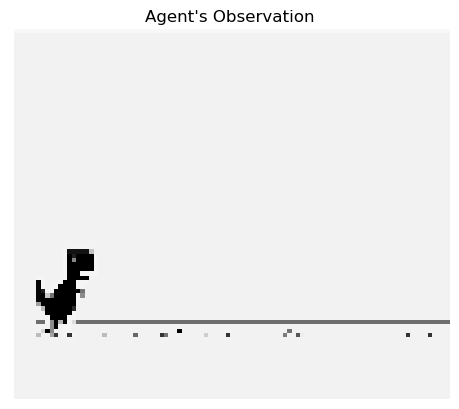

In [78]:
from matplotlib import pyplot as plt

env = WebGame()

# Получение текущего наблюдения
observation = env.get_observation()

# Печать формы наблюдения для проверки
print(observation.shape)  # Форма наблюдения

# Использование plt.imshow для отображения наблюдения
plt.imshow(observation[0], cmap='gray')  # Если изображение черно-белое, используйте cmap='gray'
plt.title("Agent's Observation")
plt.axis('off')  # Убираем оси для лучшей визуализации
plt.show()

In [68]:
# Вызов show_observation в нужный момент для отладки
game = WebGame()
game.show_observation()

In [69]:
game.close()

In [99]:
# Функция для демонстрации 10 эпизодов игры
def run_demo():
    env = WebGame()

    for episode in range(10):  # Запуск 10 игр
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = env.action_space.sample()  # Выбор случайного действия
            obs, reward, done, info = env.step(action)
            total_reward += reward

            if done:
                print(f"Episode {episode + 1} finished with score: {total_reward}")
                time.sleep(1)  # Пауза между эпизодами
                break

    env.close()

# Запуск демонстрации
run_demo()

Episode 1 finished with score: 19
Episode 2 finished with score: 25
Episode 3 finished with score: 23
Episode 4 finished with score: 20
Episode 5 finished with score: 19
Episode 6 finished with score: 19
Episode 7 finished with score: 21
Episode 8 finished with score: 28
Episode 9 finished with score: 30
Episode 10 finished with score: 19


(500, 500, 3)
False


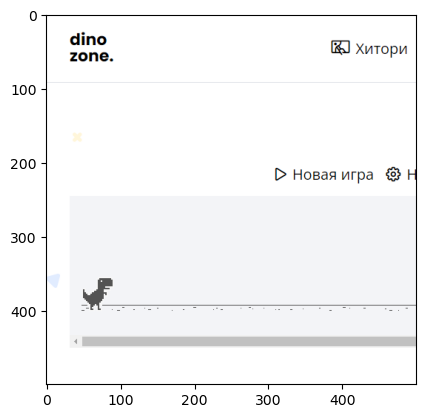

In [82]:
from matplotlib import pyplot as plt

env = WebGame()
done, done_cap = WebGame().get_done()
print(done_cap.shape)  # Game over cap shape
print(done)  # Game over text detected
plt.imshow(done_cap)

In [52]:
# Define a custom callback to save model checkpoints and track performance
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, save_path, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.save_path = save_path
        self.best_mean_reward = -float('inf')

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Save every 1000 steps
            mean_reward = self.training_env.get_attr("reward")  # Get mean reward from the environment
            if mean_reward and mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.model.save(self.save_path)
                print(f"Saving new best model with reward: {self.best_mean_reward}")
        return True

In [53]:
# Create the environment (ensure WebGame is defined with get_observation() updated)
env = WebGame()

# Ensure the tensorboard log directory exists
tensorboard_log_dir = "dqn_tensorboard/"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Initialize the model
model = DQN(
    'CnnPolicy', env, verbose=1, buffer_size=50000, batch_size=16,
    learning_starts=1000, optimize_memory_usage=False, tensorboard_log=tensorboard_log_dir
)

# Define the path to save the model
model_save_path = "best_model_dqn"

# Create the callback instance
callback = SaveOnBestTrainingRewardCallback(save_path=model_save_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [26]:
# Train the model
model.learn(model.learn(total_timesteps=10000, callback=callback, reset_num_timesteps=False))

# Save the trained model
model.save("final_model_dqn")

ValueError: could not broadcast input array from shape (187,315,3) into shape (1,84,100)

In [11]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

TypeError: The reset() method must accept a `seed` parameter

In [36]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
        return True

In [54]:
CHECKPOINT_DIR = 'train/'
LOG_DIR = 'logs/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Initialize the logging callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

model = DQN(
    'CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
    buffer_size=100000, batch_size=32, learning_starts=1000, optimize_memory_usage=False
)

# Train the model with logging callback
model.learn(total_timesteps=100000, callback=callback)

model.load(os.path.join(CHECKPOINT_DIR, 'best_model_88000'))

for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: 235620